In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kaustade nimed ja klasside määramine
class_names = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
image_data = []
labels = []
# Andmete laadimine
for idx, class_name in enumerate(class_names):
    folder_path = f"Chest X_Ray Dataset/{class_name}"
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(img)
        labels.append(idx)  # Määrake klassi indeks

In [4]:
# Muuda andmed numpy massiivideks
image_data = np.array(image_data)
labels = np.array(labels)
# Andmete jaotamine treening-, valideerimis- ja testikomplektideks
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Kasuta eelnevalt treenitud ResNet50 mudelit
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Ära treeni eelnevalt treenitud kihti

In [7]:
# Täiendame mudelit
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint  #LISATUD

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.keras"),
    save_weights_only=False,  # Salvesta kogu mudel
    save_best_only=True,  # Salvesta iga epohhi lõpus
    verbose=1,
)

In [9]:
# Treenime mudelit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=2,  # mingi 10 minimum äkki sobiks
    callbacks=[checkpoint_callback], # lisatud........
)

C:\Users\raigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5784 - loss: 1.1253
Epoch 1: val_loss improved from inf to 1.06664, saving model to model_checkpoints\model_epoch_01.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.5785 - loss: 1.1250 - val_accuracy: 0.5851 - val_loss: 1.0666
Epoch 2/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6143 - loss: 1.0152
Epoch 2: val_loss improved from 1.06664 to 1.02275, saving model to model_checkpoints\model_epoch_02.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6143 - loss: 1.0153 - val_accuracy: 0.5879 - val_loss: 1.0227


In [10]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step
[[  0   0 133   0]
 [  0   6 311   0]
 [  0   2 833   0]
 [  0   3 139   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.55      0.02      0.04       317
           2       0.59      1.00      0.74       835
           3       0.00      0.00      0.00       142

    accuracy                           0.59      1427
   macro avg       0.28      0.25      0.19      1427
weighted avg       0.47      0.59      0.44      1427



C:\Users\raigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [11]:
results = model.evaluate(X_test, y_test, batch_size=8)
print(model.metrics_names)  # Kuvab saadavalolevate mõõdikute nimed
print(results)

179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.5778 - loss: 1.0332
['loss', 'compile_metrics']
[1.022748589515686, 0.5879467129707336]


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


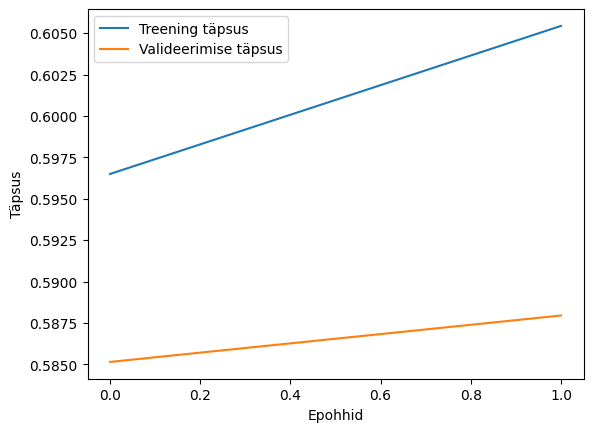

In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())  #
plt.plot(history.history["accuracy"], label="Treening täpsus")
plt.plot(history.history["val_accuracy"], label="Valideerimise täpsus")
plt.xlabel("Epohhid")
plt.ylabel("Täpsus")
plt.legend()
plt.show()

In [13]:
print(f"accuracy: {history.history['val_accuracy']}")
print(f"accuracy: {history.history['accuracy']}")

accuracy: [0.5851436853408813, 0.5879467129707336]
accuracy: [0.5964943170547485, 0.6054338216781616]


<h1>uute piltide testimine<h1>


<font color="red">Ma tegin kausta "uued" ja panin sinna pildid ja siis üritab
neid arvata</font>


In [20]:
import tensorflow as tf

new_images_path = "uued"  # Kaust, kus on uued pildid

# Kategooriate nimed
categories = ["COVID19", "PNEUMONIA", "TUBERCOLOSIS", "NORMAL"]

# Laadime uued pildid
new_images = []
for img_name in os.listdir(new_images_path):
    img_path = os.path.join(new_images_path, img_name)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    new_images.append(img_array)

# Muudame uued pildid numpy massiiviks
new_images = np.array(new_images)

# Normaliseerime pildid, et need oleksid vahemikus [0, 1]
new_images = new_images / 255.0

# Ennustamine uute piltide kohta
predictions = model.predict(new_images)

# Kuvame tulemused
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Kõrgeima tõenäosusega klass
    print(
        f"Pilt {i+1}: Ennustus: {categories[predicted_class]}, Tõenäosus: {prediction[predicted_class]:.2f}"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Pilt 1: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.62
Pilt 2: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.53
Pilt 3: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.61
Pilt 4: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.58


In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

# Lae testandmestik
test_dataset = image_dataset_from_directory(
    "Chest X_Ray Dataset",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
)

# Hindamine mudeliga
loss, accuracy = model.evaluate(test_dataset)
print(f"Testandmete täpsus: {accuracy:.2f}")

Found 7132 files belonging to 4 classes.
223/223 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.0961 - loss: 13.5555
Testandmete täpsus: 0.10


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


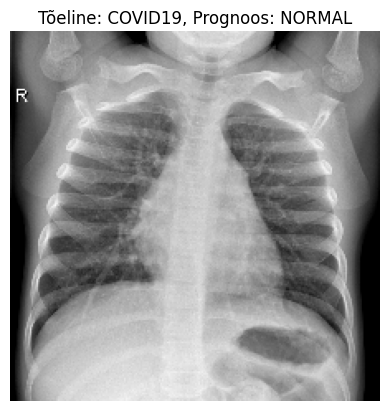

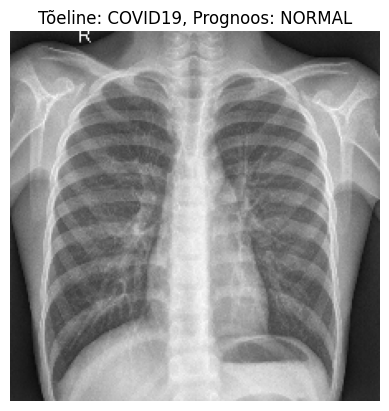

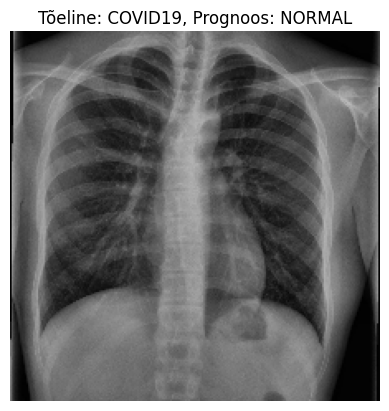

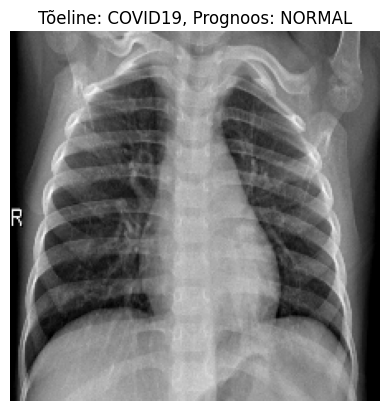

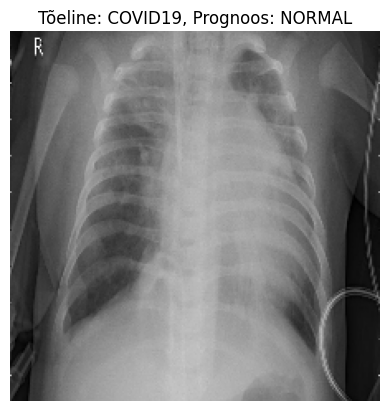

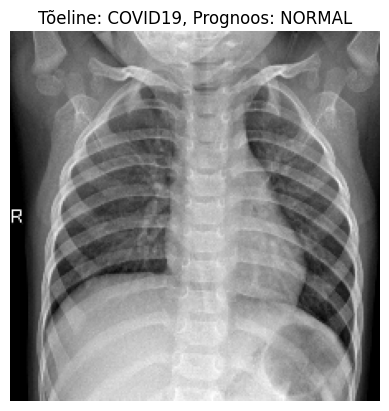

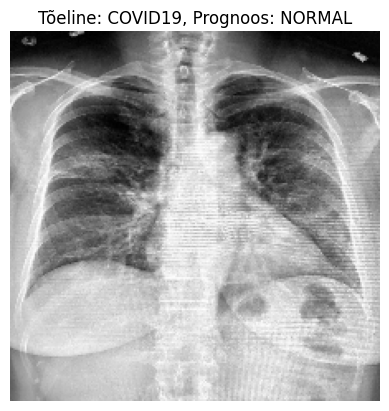

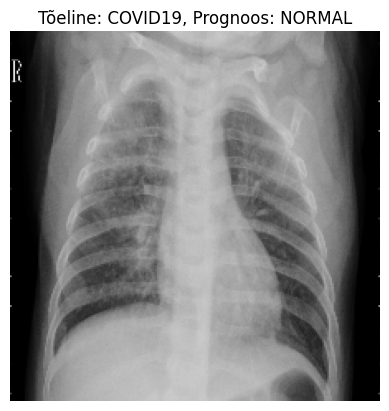

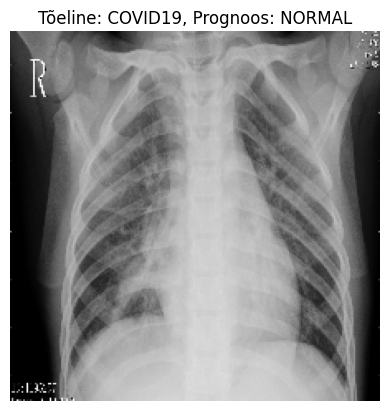

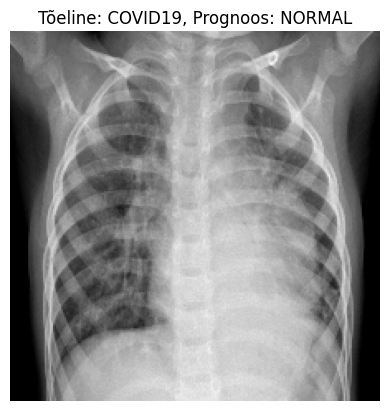

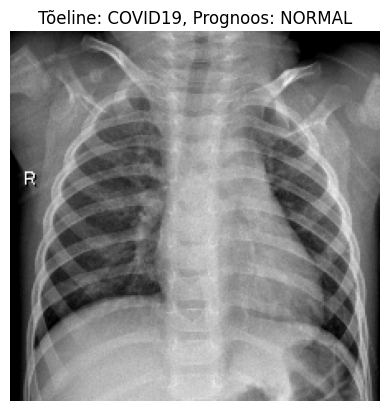

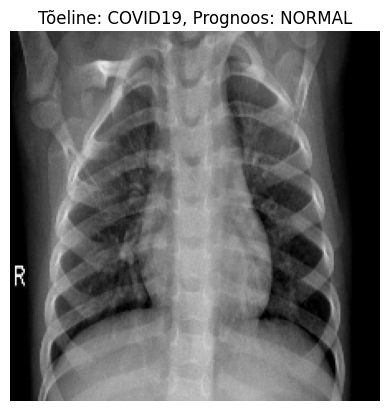

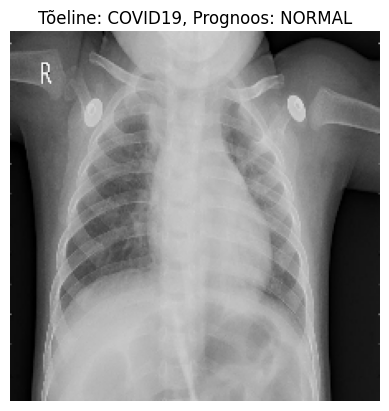

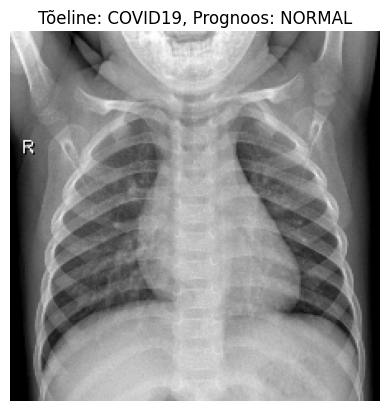

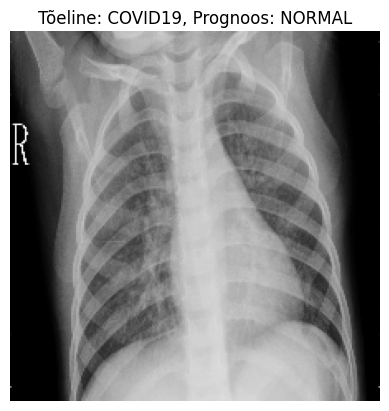

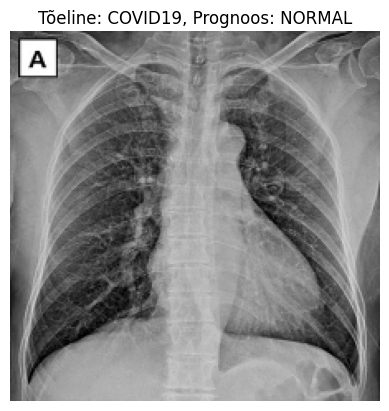

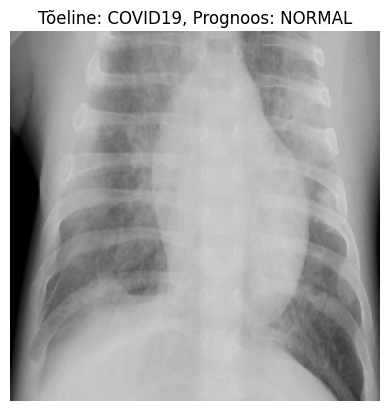

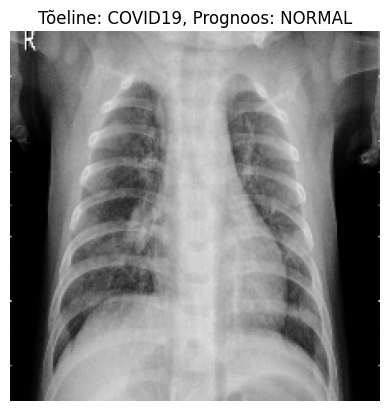

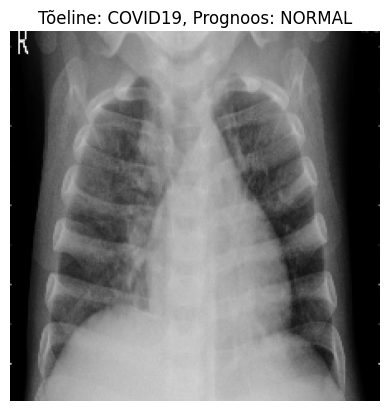

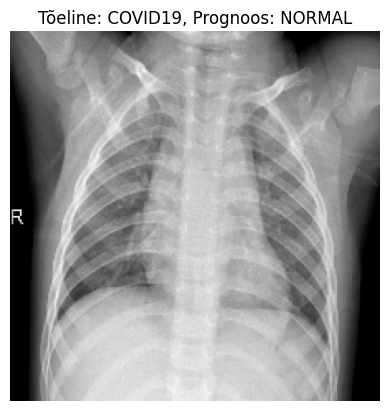

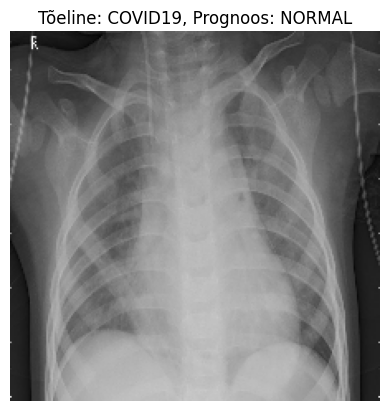

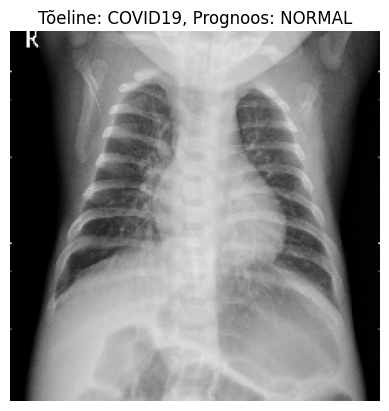

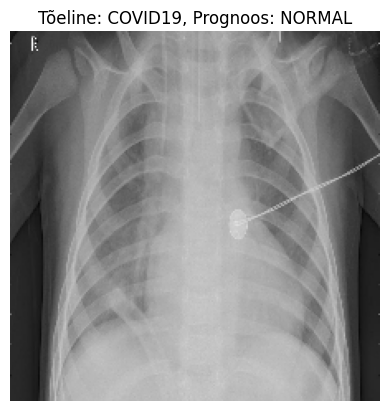

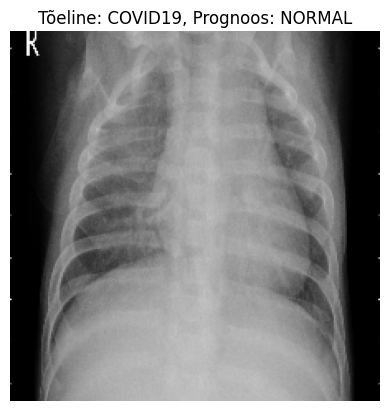

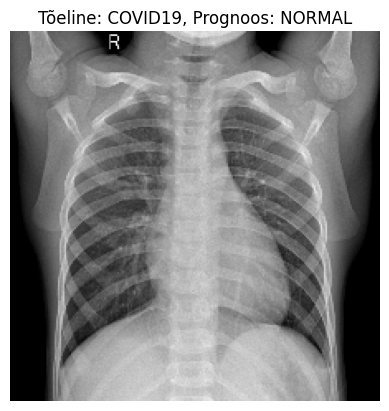

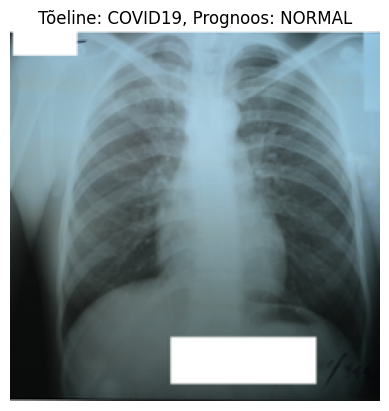

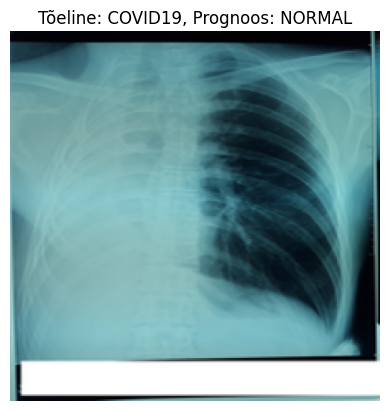

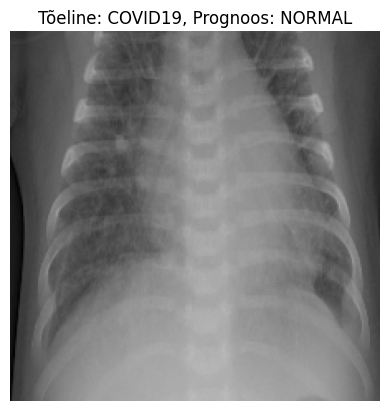

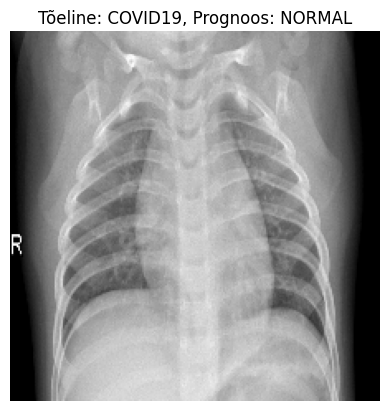

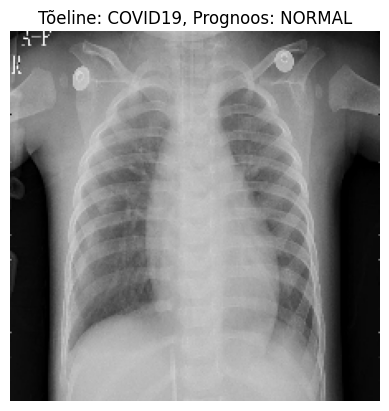

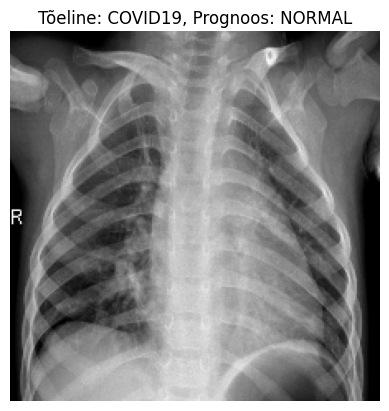

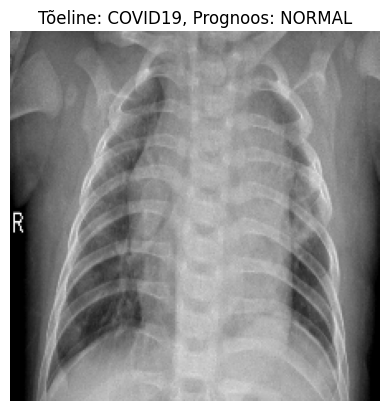

In [21]:
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):  # Võta esimene partii testandmeid
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = categories[np.argmax(predictions[i])]
        true_class = categories[np.argmax(labels[i].numpy())]
        plt.title(f"Tõeline: {true_class}, Prognoos: {predicted_class}")
        plt.axis("off")
        plt.show()

In [26]:
def load_model_from_epoch(epoch_num): #lisatud
    model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_num:02d}.keras")
    if os.path.exists(model_path):
        print(f"Laen mudelit failist: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Faili {model_path} ei leitud.")
    
loaded_model = load_model_from_epoch(1)
# Kuvage mudeli struktuur
loaded_model.summary()

# Prognoosige testandmetega
for images, labels in test_dataset.take(1):
    predictions = loaded_model.predict(images)
    print(predictions)

Laen mudelit failist: model_checkpoints\model_epoch_01.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[9.0695557e-06 2.0139007e-02 7.5988569e-03 9.7225302e-01]
 [1.1238573e-05 3.1505455e-03 5.2834116e-04 9.9630982e-01]
 [6.7690380e-05 1.6437670e-02 1.1942179e-03 9.8230046e-01]
 [3.7257864e-06 2.0750281e-03 1.4891498e-03 9.9643207e-01]
 [3.5395860e-05 3.6207065e-02 3.1668337e-03 9.6059072e-01]
 [1.1868982e-06 2.6188308e-04 5.6705810e-03 9.9406636e-01]
 [9.2012788e-06 3.9229281e-02 4.9573282e-05 9.6071196e-01]
 [5.1166635e-06 5.9094515e-02 1.5408879e-03 9.3935949e-01]
 [2.0058744e-06 9.5156180e-03 3.2124756e-04 9.9016106e-01]
 [6.1082198e-07 2.3511240e-04 5.6340192e-03 9.9413019e-01]
 [1.1801308e-06 9.6312873e-03 1.6880735e-04 9.9019873e-01]
 [5.2057953e-07 1.0923378e-02 3.4320395e-04 9.8873293e-01]
 [3.7786123e-07 7.3675760e-03 2.6996940e-04 9.9236214e-01]
 [2.9029704e-06 2.3852291e-03 4.4715733e-04 9.9716467e-01]
 [1.0652075e-05 9.0512158e-03 4.6281828e-04 9.9047536e-01]
 [1.8712579e-05 2.7963547e-02 2.7190274e-04 9.7174579e-01]
 [7.3803807e-05 1.65